In [1]:
print("hola amigo")

hola amigo


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)
# 68*32 = 2176; ie batches of all images

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 2 0 1 1 1 0 1 0 1 1 1 0 0 0 1 2 0]


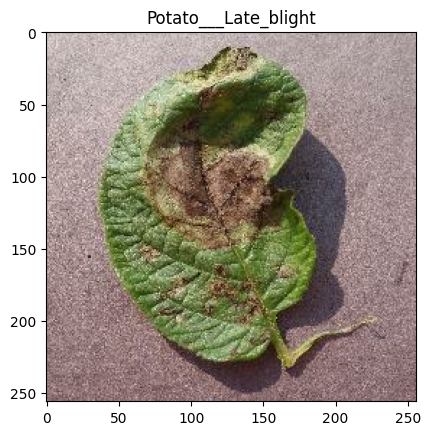

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [9]:
# # 80% => train
# # 20% => 10% validation + 10% test
train_size = 0.8
# len(dataset) * train_size
# train_ds = dataset.take(54)
# len(train_ds)
# test_ds = dataset.skip(54)
# len(test_ds)
# val_size = 0.1
# len(dataset) * val_size
# val_ds = test_ds.take(6)
# len(val_ds)
# test_ds = test_ds.skip(6)
# len(test_ds)

def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [11]:
print(len(dataset) * train_size)
print(len(val_ds))
print(len(test_ds))

54.400000000000006
6
8


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
# image > convoluton+relu > pooling > convolution+relu > pooling > flatten > is this a dog??

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [18]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4402 - loss: 0.9322 - val_accuracy: 0.6146 - val_loss: 0.7337
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6154 - loss: 0.7531 - val_accuracy: 0.7500 - val_loss: 0.5616
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7458 - loss: 0.5172 - val_accuracy: 0.7969 - val_loss: 0.5127
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8596 - loss: 0.3368 - val_accuracy: 0.8854 - val_loss: 0.2687
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8959 - loss: 0.2508 - val_accuracy: 0.9427 - val_loss: 0.1847
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8925 - loss: 0.2593 - val_accuracy: 0.9375 - val_loss: 0.1685
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9490 - loss: 0.1345 - val_accuracy: 0.9531 - val_loss: 0.1012
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9651 - loss: 0.0941 - val_accuracy: 0.8802 - val_loss:

In [19]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.9745 - loss: 0.0449


In [20]:
scores

[0.045065686106681824, 0.9765625]

In [21]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
history.history['accuracy']

[0.4826388955116272,
 0.6394675970077515,
 0.7806712985038757,
 0.8680555820465088,
 0.90625,
 0.9126157164573669,
 0.9560185074806213,
 0.9548611044883728,
 0.9583333134651184,
 0.9722222089767456,
 0.9768518805503845,
 0.9837962985038757,
 0.9866898059844971,
 0.9722222089767456,
 0.9490740895271301]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

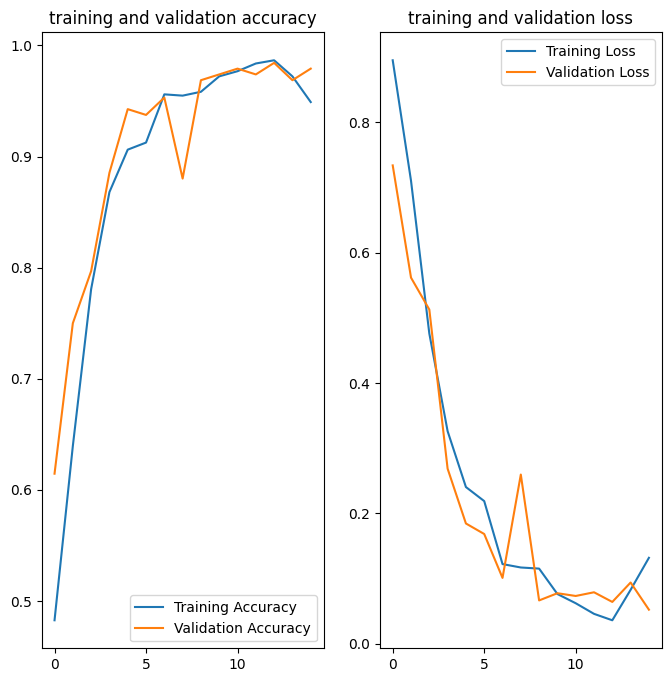

In [25]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("training and validation loss")

In [26]:
import numpy as np
np.argmax([9, 2, 12, 100])

3

In [27]:
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
#     first_image = plt.imshow(images_batch[0].numpy().astype('uint8'))
#     first_label = labels_batch[0].numpy()
#     print(f"actual label : {class_names[first_label]}")

#     batch_prediction = model.predict(images_batch)
#     print(f"predicted label: {class_names[np.argmax(batch_prediction[0])]}")

def predict(model, images):
    img_array = tf.keras.preprocessing.image.img_to_array(images[0].numpy())
    img_array = tf.expand_dims(img_array, 0) #creating a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

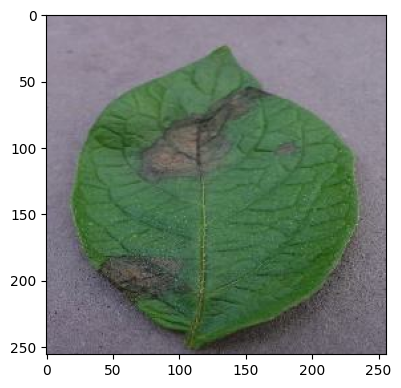

In [28]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual label      : {actual_class}\npredicted label : {predicted_class}\nconfidence : {confidence}%")
        plt.axis("off")

In [29]:
# import os
# model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
# model.save(f"../models/{model_version}.keras")

In [35]:
model_version = 1
model.save(f"D:\_programming\Potato-Disease-Classification-System-using-Convolutional-Neural-Networks-CNN\saved_models\{model_version}.keras")

In [ ]:
# Step 1: Install the necessary packages
!pip install pyngrok
!pip install -r "requirements.txt"

You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!ngrok authtoken 2ioz4KXy12YAwiMV6Zo84Haun8W_6j9wVkAeJX6LPVUrGRTr3

Authtoken saved to configuration file: C:\Users\ASUS\AppData\Local/ngrok/ngrok.yml


In [ ]:
!nohup streamlit run streamlit_app.py &

In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(8501)
print(public_url)

In [1]:
# NgrokTunnel: "https://ec33-34-106-160-128.ngrok-free.app" -> "http://localhost:8501"
